### Siamese Network

Experiment to use a siamese network like outlined in https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d or https://github.com/aspamers/siamese

For the beginning we follow : https://mc.ai/advance-ai-face-recognition-using-siamese-networks/


In [5]:
# load dcim image for processing 
#!pip install pydicom

In [6]:
# try adabound optimizer
# see https://pypi.org/project/keras-adabound/
# and description on https://github.com/Luolc/AdaBound
#!pip install keras-adabound

In [7]:
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path

import cv2
import pandas as pd

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#from sklearn.preprocessing import LabelBinarizer


import tensorflow.keras.backend as K

import tensorflow.keras as keras

import time
import seaborn as sns

import numpy as np

#import numpy.random as rng
#from sklearn.utils import shuffle

%matplotlib inline

In [8]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [9]:
project_dir = '/gdrive/My Drive/DL/FinalProject'

images_dir = project_dir + '/data/images_PW'
%cd {project_dir} 
%pwd

/gdrive/My Drive/DL/FinalProject


'/gdrive/My Drive/DL/FinalProject'

In [10]:
%load_ext autoreload
%autoreload
%reload_ext autoreload

src_dir = os.path.join(project_dir, 'src')


In [11]:
#!ls -l '/gdrive/My Drive/DL/FinalProject/src'


In [12]:
q = [print(p) for p in sys.path]


/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython


In [13]:
sys.path.insert(0, src_dir)

In [14]:
data_dir = os.path.join(project_dir, 'data')
images_dir = os.path.join(data_dir, 'images_PW')
from cnn_helper import *

In [15]:
tdf = load_json_as_df(data_dir, 'mri-images')

loaded mri-images.json with shape (309, 7)



In [16]:
col = 'perspective'
classes_df = tdf.groupby(by=[col])
available_classes = set(classes_df.groups.keys())
available_classes

{'AX', 'COR', 'SAG'}

### Create pairs of images

A siamese network processes 2 inputs through 2 networks sharing their weights and outputs 2 vectors which can be seen as embedding of the 2 inputs in a feature space. These 2 embedding vectors are then compared for (dis)similarity by different methods, e.g. by calculating their distance or by feeding them into a second network. 

we follow http://sujitpal.blogspot.com/2017/02/using-keras-imagedatagenerator-with.html

In [17]:
tdf

,patient-id,perspective,sequence,perspective-sequence,labels,image-number,image-name
0,TCGA060173,AX,PWI,AX-PWI,"[AX, PWI]",1,AX_PWI_Glioma_GBM_TCGA060173_1.jpg
1,TCGA766662,AX,ADC,AX-ADC,"[AX, ADC]",1,AX_ADC_Glioma_GBM_TCGA766662_1.jpg
2,TCGA766663,COR,T1KM,COR-T1KM,"[COR, T1KM]",2,COR_T1KM_Glioma_GBM_TCGA766663_2.jpg
3,TCGA060171,COR,T1KM,COR-T1KM,"[COR, T1KM]",2,COR_T1KM_Glioma_GBM_TCGA060171_2.jpg
4,TCGA141829,AX,DWI,AX-DWI,"[AX, DWI]",1,AX_DWI_Glioma_GBM_TCGA141829_1.jpg
...,...,...,...,...,...,...,...
304,TCGA020069,SAG,T1KM,SAG-T1KM,"[SAG, T1KM ]",,SAG_T1KM _Glioma_GBM_TCGA020069.jpg
305,TCGA141037,SAG,T1,SAG-T1,"[SAG, T1]",1,SAG_T1_Glioma_GBM_TCGA141037_1.jpg
306,TCGA020054,COR,Misc,COR-Misc,"[COR, Misc ]",1,COR_Misc _Glioma_GBM_TCGA020054_1.jpg
307,TCGA061084,COR,T1KM,COR-T1KM,"[COR, T1KM]",3,COR_T1KM_Glioma_GBM_TCGA061084_3.jpg


In [18]:
batch_size = 32
image_size = (224, 224)
input_shape = (image_size[0], image_size[1], 3)
epochs = 20

#### Create samples for each class containing class samples and samples from other classes


In [19]:
print(f'Number of available classes: {len(available_classes)}')
p = [print(f'Class: {key}\t Size: {len(classes_df.get_group(key))}') for key in available_classes]

Number of available classes: 3
Class: SAG	 Size: 66
Class: AX	 Size: 169
Class: COR	 Size: 74


Here we create labelled pairs of images alternately belonging to same class (label=1) 
or different class (label=0).
These pairs are feed into the siamese network to create an embedding and the embeddings together with the label are evaluated with the contrastive loss function.

An other possibility to explore is to use triplet loss function (see e.g. https://gombru.github.io/2019/04/03/ranking_loss/ )

Create a different sample function for it ( see https://www.tensorflow.org/addons/tutorials/losses_triplet )

In [20]:
def cls_sample_pairs(df, cls_column, cls_name, n_samples_per_class=10, column='image-name', random_state=47):
    """

    """
    pos_df = df[df[cls_column] == cls_name]
    neg_df = df[df[cls_column] != cls_name]
    replace = True

    # samples for same class image pairs
    cls_pos_df_first = pos_df.sample(n=n_samples_per_class, replace=replace, random_state=random_state)
    cls_pos_df_second = pos_df.sample(n=n_samples_per_class, replace=replace, random_state= 2 * random_state)

    # samples for different classes image pairs
    cls_pos_df_third = pos_df.sample(n=n_samples_per_class, replace=replace, random_state=random_state)
    cls_neg_df = neg_df.sample(n=n_samples_per_class, replace=replace, random_state= 3 * random_state)

    # create pairs and labels
    pairs = []
    labels = []

    for i in range(n_samples_per_class):
        same_pair = [
            cls_pos_df_first.iloc[i][column],
            cls_pos_df_second.iloc[i][column]
        ]
        other_pair = [cls_pos_df_third.iloc[i][column], cls_neg_df.iloc[i][column]]
        pairs += [same_pair, other_pair]
        labels += [1, 0]

    return pairs, labels

In [21]:
def create_pairs_all_classes(df, col, n_samples_per_class=10, column='image-name', random_state=47):
    """
    """
    cls = df[col].unique()
    all_pairs = []
    all_labels = []
    for c in cls:
        pairs, labels = cls_sample_pairs(df, col, c, n_samples_per_class, column, random_state)
        all_pairs += pairs
        all_labels += labels

    return all_pairs, all_labels
    

#### Create train validation split

In [22]:
from sklearn.model_selection import train_test_split
train_df, validation_df = train_test_split(tdf, test_size=0.2, stratify=tdf[col])
#train_df, validation_df = train_test_split(tdf, test_size=0.2)

In [23]:
trainclasses_df = train_df.groupby(by=[col])
#available_classes = set(classes_df.groups.keys())
print(f'Number of available classes: {len(set(trainclasses_df.groups.keys()))}')
p = [print(f'Class: {key}\t Size: {len(trainclasses_df.get_group(key))}') for key in set(trainclasses_df.groups.keys())]

Number of available classes: 3
Class: SAG	 Size: 53
Class: AX	 Size: 135
Class: COR	 Size: 59


#### Create pairs of images

In [24]:
train_pairs, train_labels = create_pairs_all_classes(train_df, col, n_samples_per_class=120, random_state=42)
print(len(train_pairs))

720


In [25]:
validation_pairs, validation_labels = create_pairs_all_classes(validation_df, col, n_samples_per_class=30, random_state=47)
validation_pairs[0:2]

[['COR_T1KM_Glioma_GBM_TCGA020027_1.jpg',
  'COR_T1KM_Glioma_GBM_TCGA120829_2.jpg'],
 ['COR_T1KM_Glioma_GBM_TCGA020027_1.jpg',
  'SAG_T1KM_Glioma_GBM_TCGA020046_1.jpg']]

#### Create Image Generator

Now we have created a list of pairs of image names which are labelled if they are from the same class or not
This pairs we feed into an image generator to augment images and create a batch of images 

we use http://sujitpal.blogspot.com/2017/02/using-keras-imagedatagenerator-with.html

(256, 256, 3)
{'theta': -2.50919762305275, 'tx': 0.23076572488187708, 'ty': 0.11878089820743942, 'shear': 9.865848419703658e-05, 'zx': 0.9312037280884873, 'zy': 0.9311989040672406, 'flip_horizontal': 1, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': 1.0404460046972834}
0.0 255.0
0.0 1.0


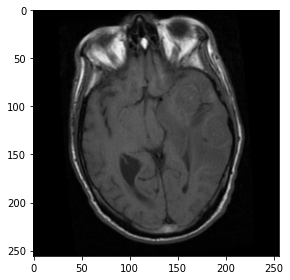

{'theta': -1.3610996271576852, 'tx': -0.10689068021860254, 'ty': 0.05726868209785829, 'shear': -0.00036050613934795816, 'zx': 0.9584289297070436, 'zy': 0.9732723686587383, 'flip_horizontal': 1, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': 0.8798695128633439}
0.0 255.0
0.0 1.0


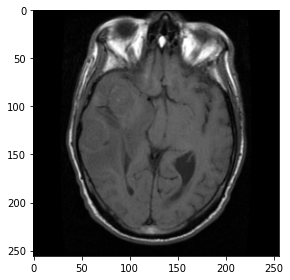

{'theta': -3.9077246165325867, 'tx': -0.20599187762873145, 'ty': 0.0943273095742243, 'shear': -5.98475062603987e-05, 'zx': 0.9244076469689558, 'zy': 0.9990353820222541, 'flip_horizontal': 1, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': 0.9035119926400068}
0.0 255.0
0.0 1.0


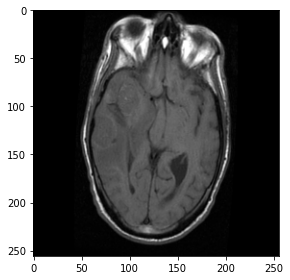

{'theta': 1.9579995762217024, 'tx': 0.21599960833183585, 'ty': -0.21069183894941723, 'shear': -0.0003040171375808548, 'zx': 0.9090454577821077, 'zy': 0.9650660661526529, 'flip_horizontal': 1, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': 1.1314950036607718}
0.0 224.0
0.0 0.8784314


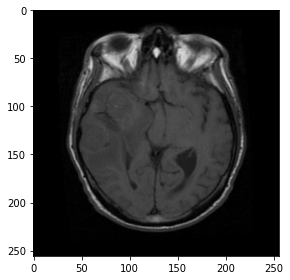

In [26]:
def draw_images(subplot, image, title):
    plt.subplot(subplot)
    plt.imshow(image)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
# rescale does not work with random_transform -> rescale image after random_transform
imagegen_parameters = dict(
       rescale=1./255,
       rotation_range=10.0,
       width_shift_range=0.001,
       height_shift_range=0.001,
       shear_range=0.0005,
       zoom_range=[0.9, 1.1],
       horizontal_flip=True,
       vertical_flip=False,
       brightness_range=(0.8,1.2),
       fill_mode='nearest',
)


datagen = tf.keras.preprocessing.image.ImageDataGenerator(**imagegen_parameters)

sid = 150
np.random.seed(42)
image = cv2.imread(os.path.join(images_dir, 'AX_T1_Glioma_GBM_TCGA120769_1.jpg'))
print(image.shape)
sid += 1
#draw_image(sid, image, "orig")
plt.imshow(image)
for j in range(4):
    random_transform = datagen.get_random_transform(image.shape, seed=None)
    print(random_transform)
    augmented = datagen.random_transform(image)  
    sid += 1
    print(augmented.min(),augmented.max())
    # rescale does not work with random_transform -> rescale image after random_transform
    augmented=augmented/255
    print(augmented.min(),augmented.max())
    plt.imshow(augmented)
    plt.tight_layout()
    plt.show()
    #draw_image(sid, augmented, "aug#{:d}".format(j + 1))



AX_PD_Glioma_GBM_TCGA060173_1.jpg


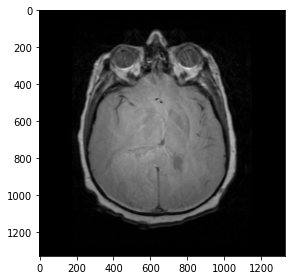

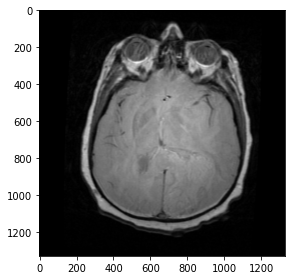

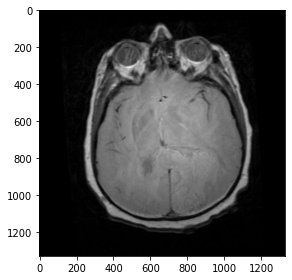

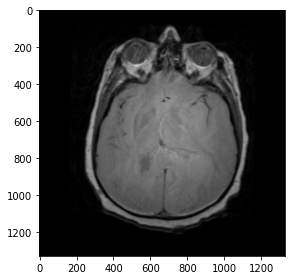

SAG_T1_Glioma_GBM_TCGA060189_1.jpg


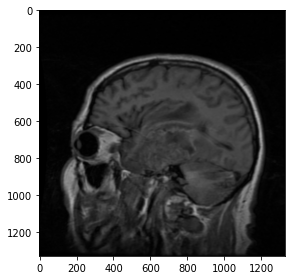

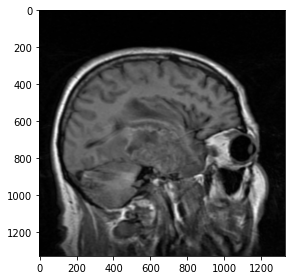

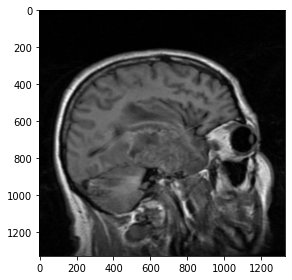

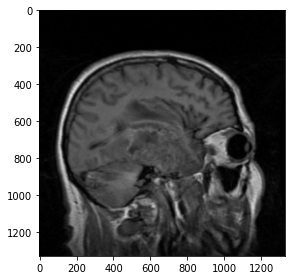

<Figure size 432x288 with 0 Axes>

In [27]:
datagens = [tf.keras.preprocessing.image.ImageDataGenerator(**imagegen_parameters),
            tf.keras.preprocessing.image.ImageDataGenerator(**imagegen_parameters)]

image_pair_tuple = [('AX_PD_Glioma_GBM_TCGA060173_1.jpg', 'SAG_T1_Glioma_GBM_TCGA060189_1.jpg', 0)]
image_pair = np.array(image_pair_tuple[0][0:2])
sid = 240
for i, image_name in enumerate(image_pair):
    print(image_name)
    image = plt.imread(os.path.join(images_dir, image_name))
    sid += 1
    plt.imshow(image)
    plt.tight_layout()
    plt.show()
    # make sure the two image data generators generate same transformations
    np.random.seed(42)
    for j in range(3):
        
        augmented = datagens[i].random_transform(image)
        augmented=augmented/255
        #print(augmented)
        sid += 1
        plt.imshow(augmented)
        plt.tight_layout()
        plt.show()

plt.tight_layout()
plt.show()

#### Image generator for training  and validation batches

In [28]:
%load_ext autoreload
%autoreload
%reload_ext autoreload
from image_pair_generator import ImagePairGenerator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
generator = ImagePairGenerator()

pairs_batch_gen = generator.generate_image_pairs(
    train_pairs,
    train_labels,
    batch_size,
    image_size,
    images_dir
)

validation_pairs_batch_gen = generator.generate_image_pairs(
    validation_pairs,
    validation_labels,
    batch_size,
    image_size,
    images_dir
)  

In [30]:
print(len(train_pairs))
print(batch_size)
print(len(train_pairs) // batch_size)

720
32
22


In [31]:
print(len(validation_pairs))
print(batch_size)
print(len(validation_pairs) // batch_size)

180
32
5


### Create Siamese Network

(copy from# https://github.com/keras-team/keras/blob/master/examples/mnist_siamese.py)

In [32]:
resnet = tf.keras.applications.resnet50.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
)

In [35]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [36]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return shape1[0], 1


def contrastive_loss(y_true, y_pred, margin=5.0):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    y_true = tf.dtypes.cast(y_true, y_pred.dtype)
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


# use trained resnet50 as base model
def create_base_model():
    # load resnet as base model

    last_layer = resnet.get_layer('conv5_block3_out')
    conv_model = models.Model(
        inputs=resnet.input,
        outputs=last_layer.output
    )

    resnet.trainable = False

    # freeze resnet layers
    #for layer in conv_model.layers:
    #    layer.trainable = False

    # open all of conf layer block 5 (conf5)
    for layer in conv_model.layers:
        if 'conv5_block' in layer.name:
            layer.trainable = True
        if 'conv4_block' in layer.name:
            layer.trainable = True

    # add new layers to create an embedding
    # use resnet at the beginning
    inputs = keras.Input(shape=input_shape)
    x = conv_model(inputs, training=True)
    #x = keras.layers.SeparableConv2D(512, 3, padding="same")(x)
    #x = keras.layers.BatchNormalization()(x)
    #x = keras.layers.Activation('relu')(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(128)(x)
    base_model = keras.Model(inputs, outputs)
    #base_model = models.Sequential()
    #base_model.add(conv_model)
    #base_model.add(tf.keras.layers.GlobalAveragePooling2D())
    #base_model.add(layers.Dense(128))

    return base_model


base_network = create_base_model()

base_network.summary()

input_a = layers.Input(shape=input_shape)
input_b = layers.Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
embedding_a = base_network(input_a)
embedding_b = base_network(input_b)


l1_layer = layers.Lambda(lambda tensor: K.abs(tensor[0] - tensor[1]))
l1_distance = l1_layer([embedding_a, embedding_b])

drop = layers.Dropout(0.5)(l1_distance)
prediction = layers.Dense(1, activation='sigmoid')(drop)
model = models.Model(inputs=[input_a, input_b], outputs=prediction)

#distance = layers.Lambda(
#    function=euclidean_distance,
#    output_shape=eucl_dist_output_shape)([embedding_a, embedding_b])

#model = models.Model([input_a, input_b], distance)
# model = models.Model(
#    inputs=[input_a, input_b],
#    outputs=euclidean_distance([embedding_a, embedding_b])
#)

print("--------------")
model.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
model_3 (Model)              (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
Total params: 23,849,984
Trainable params: 22,346,880
Non-trainable params: 1,503,104
_________________________________________________________________
--------------
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6

In [37]:
base_network.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
model_3 (Model)              (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
Total params: 23,849,984
Trainable params: 22,346,880
Non-trainable params: 1,503,104
_________________________________________________________________


In [38]:
from datetime import datetime as datetime

logs = "data/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Uncomment when running for the fist time and change file name accordingly
logs = "data/logs/" +"siamese_network"

tboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = logs,
    histogram_freq = 1,
    profile_batch = '500,520'
)

In [39]:
siamese_checkpoint_path = "./siamese_checkpoint"

siamese_callbacks = [
    #EarlyStopping(monitor='accuracy', min_delta=0.01, patience=10, verbose=0),
    ModelCheckpoint(siamese_checkpoint_path, monitor='accuracy', save_best_only=True, verbose=0),
    tboard_callback
]

In [40]:
from keras_adabound import AdaBound
adabound = AdaBound(lr=1e-003,
                final_lr=0.1,
                gamma=1e-03,
                weight_decay=0.)

In [42]:
# rms = tf.keras.optimizers.RMSprop()

adam = keras.optimizers.Adam(learning_rate=0.003)

# model.compile(loss=contrastive_loss, optimizer=adam, metrics=['accuracy'])
model.compile(loss="binary_crossentropy", optimizer=adam, metrics=['accuracy'])

In [43]:
epochs = 20

In [44]:
history = model.fit(
    pairs_batch_gen,
    validation_data=validation_pairs_batch_gen,
    batch_size=batch_size,
    steps_per_epoch=len(train_labels) // batch_size,
    validation_steps=len(validation_labels) // batch_size,
    # callbacks=siamese_callbacks,
    epochs=epochs
)

Epoch 1/20
22/22 [==============================] - 40s 2s/step - loss: 0.7137 - accuracy: 0.4972 - val_loss: 0.6938 - val_accuracy: 0.5250
Epoch 2/20
22/22 [==============================] - 34s 2s/step - loss: 0.6888 - accuracy: 0.5227 - val_loss: 0.7004 - val_accuracy: 0.4750
Epoch 3/20
22/22 [==============================] - 34s 2s/step - loss: 0.6968 - accuracy: 0.5270 - val_loss: 0.6975 - val_accuracy: 0.4750
Epoch 4/20
22/22 [==============================] - 34s 2s/step - loss: 0.6865 - accuracy: 0.5426 - val_loss: 0.6882 - val_accuracy: 0.5375
Epoch 5/20
22/22 [==============================] - 34s 2s/step - loss: 0.6445 - accuracy: 0.6293 - val_loss: 0.6253 - val_accuracy: 0.6687
Epoch 6/20
22/22 [==============================] - 34s 2s/step - loss: 0.6009 - accuracy: 0.7045 - val_loss: 0.5512 - val_accuracy: 0.7063
Epoch 7/20
22/22 [==============================] - 34s 2s/step - loss: 0.5749 - accuracy: 0.6875 - val_loss: 0.5525 - val_accuracy: 0.6562
Epoch 8/20
22/22 [==

In [45]:
history_2 = model.fit(
    pairs_batch_gen,
    validation_data=validation_pairs_batch_gen,
    batch_size=batch_size,
    steps_per_epoch=len(train_labels) // batch_size,
    validation_steps=len(validation_labels) // batch_size,
    # callbacks=siamese_callbacks,
    epochs=epochs
)

Epoch 1/20
22/22 [==============================] - 34s 2s/step - loss: 0.3522 - accuracy: 0.8438 - val_loss: 0.4655 - val_accuracy: 0.7688
Epoch 2/20
22/22 [==============================] - 34s 2s/step - loss: 0.3869 - accuracy: 0.8338 - val_loss: 0.4122 - val_accuracy: 0.7750
Epoch 3/20
22/22 [==============================] - 34s 2s/step - loss: 0.3649 - accuracy: 0.8423 - val_loss: 0.4311 - val_accuracy: 0.7812
Epoch 4/20
22/22 [==============================] - 34s 2s/step - loss: 0.3363 - accuracy: 0.8707 - val_loss: 0.3826 - val_accuracy: 0.8125
Epoch 5/20
22/22 [==============================] - 34s 2s/step - loss: 0.3305 - accuracy: 0.8679 - val_loss: 0.3168 - val_accuracy: 0.8438
Epoch 6/20
22/22 [==============================] - 33s 2s/step - loss: 0.3328 - accuracy: 0.8537 - val_loss: 0.3862 - val_accuracy: 0.8062
Epoch 7/20
22/22 [==============================] - 33s 2s/step - loss: 0.3764 - accuracy: 0.8438 - val_loss: 0.4014 - val_accuracy: 0.8125
Epoch 8/20
22/22 [==

In [46]:
history_3 = model.fit(
    pairs_batch_gen,
    validation_data=validation_pairs_batch_gen,
    batch_size=batch_size,
    steps_per_epoch=len(train_labels) // batch_size,
    validation_steps=len(validation_labels) // batch_size,
    # callbacks=siamese_callbacks,
    epochs=epochs
)

Epoch 1/20
22/22 [==============================] - 34s 2s/step - loss: 0.2601 - accuracy: 0.9006 - val_loss: 0.3684 - val_accuracy: 0.8500
Epoch 2/20
22/22 [==============================] - 34s 2s/step - loss: 0.2857 - accuracy: 0.8821 - val_loss: 0.3341 - val_accuracy: 0.8500
Epoch 3/20
22/22 [==============================] - 34s 2s/step - loss: 0.2690 - accuracy: 0.8949 - val_loss: 0.3979 - val_accuracy: 0.8188
Epoch 4/20
22/22 [==============================] - 34s 2s/step - loss: 0.2678 - accuracy: 0.8906 - val_loss: 0.2684 - val_accuracy: 0.8813
Epoch 5/20
22/22 [==============================] - 34s 2s/step - loss: 0.2552 - accuracy: 0.9091 - val_loss: 0.3436 - val_accuracy: 0.8813
Epoch 6/20
22/22 [==============================] - 34s 2s/step - loss: 0.3017 - accuracy: 0.8764 - val_loss: 0.2819 - val_accuracy: 0.8875
Epoch 7/20
22/22 [==============================] - 34s 2s/step - loss: 0.2375 - accuracy: 0.9062 - val_loss: 0.3550 - val_accuracy: 0.8438
Epoch 8/20
22/22 [==

In [47]:
history_4 = model.fit(
    pairs_batch_gen,
    validation_data=validation_pairs_batch_gen,
    batch_size=batch_size,
    steps_per_epoch=len(train_labels) // batch_size,
    validation_steps=len(validation_labels) // batch_size,
    # callbacks=siamese_callbacks,
    epochs=epochs
)

Epoch 1/20
22/22 [==============================] - 34s 2s/step - loss: 0.2730 - accuracy: 0.8920 - val_loss: 0.2848 - val_accuracy: 0.8750
Epoch 2/20
22/22 [==============================] - 34s 2s/step - loss: 0.2581 - accuracy: 0.8963 - val_loss: 0.3424 - val_accuracy: 0.8687
Epoch 3/20
22/22 [==============================] - 34s 2s/step - loss: 0.2666 - accuracy: 0.9020 - val_loss: 0.2606 - val_accuracy: 0.8750
Epoch 4/20
22/22 [==============================] - 34s 2s/step - loss: 0.2616 - accuracy: 0.8935 - val_loss: 0.2961 - val_accuracy: 0.9000
Epoch 5/20
22/22 [==============================] - 34s 2s/step - loss: 0.2135 - accuracy: 0.9233 - val_loss: 0.3061 - val_accuracy: 0.8562
Epoch 6/20
22/22 [==============================] - 33s 2s/step - loss: 0.2145 - accuracy: 0.9205 - val_loss: 0.2963 - val_accuracy: 0.8625
Epoch 7/20
22/22 [==============================] - 33s 2s/step - loss: 0.2040 - accuracy: 0.9176 - val_loss: 0.2895 - val_accuracy: 0.9000
Epoch 8/20
22/22 [==

In [48]:
history_5 = model.fit(
    pairs_batch_gen,
    validation_data=validation_pairs_batch_gen,
    batch_size=batch_size,
    steps_per_epoch=len(train_labels) // batch_size,
    validation_steps=len(validation_labels) // batch_size,
    # callbacks=siamese_callbacks,
    epochs=epochs
)

Epoch 1/20
22/22 [==============================] - 34s 2s/step - loss: 0.1439 - accuracy: 0.9446 - val_loss: 0.3129 - val_accuracy: 0.8813
Epoch 2/20
22/22 [==============================] - 34s 2s/step - loss: 0.1884 - accuracy: 0.9332 - val_loss: 0.2239 - val_accuracy: 0.8750
Epoch 3/20
22/22 [==============================] - 34s 2s/step - loss: 0.1687 - accuracy: 0.9347 - val_loss: 0.2549 - val_accuracy: 0.9187
Epoch 4/20
22/22 [==============================] - 34s 2s/step - loss: 0.2015 - accuracy: 0.9176 - val_loss: 0.2542 - val_accuracy: 0.9062
Epoch 5/20
22/22 [==============================] - 34s 2s/step - loss: 0.1755 - accuracy: 0.9389 - val_loss: 0.2758 - val_accuracy: 0.8938
Epoch 6/20
22/22 [==============================] - 34s 2s/step - loss: 0.1958 - accuracy: 0.9261 - val_loss: 0.2784 - val_accuracy: 0.8687
Epoch 7/20
22/22 [==============================] - 34s 2s/step - loss: 0.1877 - accuracy: 0.9318 - val_loss: 0.3153 - val_accuracy: 0.8875
Epoch 8/20
22/22 [==

In [49]:
history_6 = model.fit(
    pairs_batch_gen,
    validation_data=validation_pairs_batch_gen,
    batch_size=batch_size,
    steps_per_epoch=len(train_labels) // batch_size,
    validation_steps=len(validation_labels) // batch_size,
    # callbacks=siamese_callbacks,
    epochs=epochs
)

Epoch 1/20
22/22 [==============================] - 34s 2s/step - loss: 0.1522 - accuracy: 0.9474 - val_loss: 0.2682 - val_accuracy: 0.9000
Epoch 2/20
22/22 [==============================] - 35s 2s/step - loss: 0.1122 - accuracy: 0.9616 - val_loss: 0.1557 - val_accuracy: 0.9312
Epoch 3/20
22/22 [==============================] - 34s 2s/step - loss: 0.1444 - accuracy: 0.9474 - val_loss: 0.2141 - val_accuracy: 0.9312
Epoch 4/20
22/22 [==============================] - 34s 2s/step - loss: 0.0974 - accuracy: 0.9744 - val_loss: 0.1993 - val_accuracy: 0.9125
Epoch 5/20
22/22 [==============================] - 34s 2s/step - loss: 0.1406 - accuracy: 0.9446 - val_loss: 0.1596 - val_accuracy: 0.9438
Epoch 6/20
22/22 [==============================] - 34s 2s/step - loss: 0.1298 - accuracy: 0.9560 - val_loss: 0.2382 - val_accuracy: 0.9062
Epoch 7/20
22/22 [==============================] - 33s 2s/step - loss: 0.1129 - accuracy: 0.9588 - val_loss: 0.2941 - val_accuracy: 0.8625
Epoch 8/20
22/22 [==

In [50]:
model.save('resnet50_siamese_binary_crossentropy_120.h5')

In [ ]:
history_7 = model.fit(
    pairs_batch_gen,
    validation_data=validation_pairs_batch_gen,
    batch_size=batch_size,
    steps_per_epoch=len(train_labels) // batch_size,
    validation_steps=len(validation_labels) // batch_size,
    # callbacks=siamese_callbacks,
    epochs=epochs
)

In [56]:
#base_network.save('resnet50_siamese_base_network.h5')

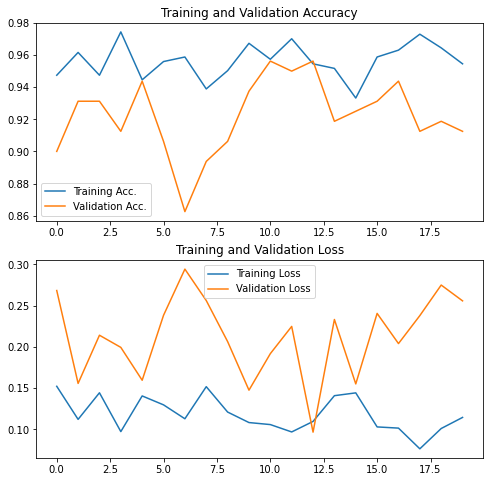

In [53]:
plot_training_history(history_6, 'accuracy')

In [54]:
def load_image(images_dir, image_names, image_size):
  images = []
  for name in image_names:
    image_path = os.path.join(images_dir, name)
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    imagge = image/255
    images.append(image)
  return np.array(images)

In [55]:
test_image_names = tdf['image-name']
test_image_classes = tdf['perspective']
unique_names = set(test_image_names)
len(unique_names)
test_images = load_image(images_dir, unique_names, image_size)

In [56]:
preds = base_network.predict(test_images)

In [65]:
test_image_labels = tdf['labels']
for name in test_image_labels:
  print(name)

['AX', 'PWI']
['AX', 'ADC']
['COR', 'T1KM']
['COR', 'T1KM']
['AX', 'DWI']
['AX', 'T2']
['AX', 'T2']
['AX', 'DWI']
['COR', 'T1KM']
['SAG', 'T1KM']
['AX', 'DWI']
['COR', 'T1KM']
['AX', 'PWI']
['AX', 'PWI']
['COR', 'T1KM']
['COR', 'T1KM ']
['SAG', 'T1KM']
['SAG', 'T1KM ']
['AX', 'ADC']
['COR', 'T1KM']
['AX', 'T1 ']
['AX', 'DWI']
['SAG', 'T1']
['COR', 'T1KM']
['AX', 'DWI']
['AX', 'DWI']
['AX', 'T1']
['SAG', 'T1']
['AX', 'PWI']
['COR', 'T1KM']
['AX', 'T2']
['AX', 'DWI']
['AX', 'ADC']
['COR', 'T1KM ']
['AX', 'T1']
['AX', 'T1']
['SAG', 'T1']
['AX', 'T2']
['AX', 'T1KM']
['SAG', 'T1']
['AX', 'T2']
['COR', 'T1KM']
['AX', 'T1KM']
['AX', 'T2']
['AX', 'T1KM']
['SAG', 'T1KM']
['AX', 'T2KM']
['AX', 'DWI']
['SAG', 'T1']
['AX', 'T2']
['AX', 'Misc']
['COR', 'T1KM']
['AX', 'T2']
['AX', 'T1KM']
['AX', 'T1']
['SAG', 'T1KM ']
['AX', 'T2']
['AX', 'T1']
['SAG', 'T1']
['COR', 'T1KM']
['SAG', 'T1']
['COR', 'T1KM']
['AX', 'T2']
['AX', 'DWI']
['AX', 'T2']
['AX', 'T2']
['COR', 'T1KM']
['AX', 'Misc']
['AX', 'T2']
[

In [67]:
# Save test embeddings for visualization in projector
#vecs_filename = 'siamese_vecs_18.07.2020.tsv'
meta_filename = 'siamese_meta_with_classes_18.07.2020.tsv'

np.savetxt(vecs_filename, preds, delimiter='\t')

out_m = open(meta_filename, 'w', encoding='utf-8')
#for name in unique_names:
for name in test_image_labels:
    out_m.write(f'{str(name)} \n')
out_m.close()


try:
  from google.colab import files
  files.download(vecs_filename)
  files.download(meta_filename)
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# compute final accuracy on training and test sets
"""
y_pred = model.predict(pairs_batch_gen)
tr_acc = compute_accuracy(train_labels, y_pred)
y_pred = model.predict(validation_pairs)
te_acc = compute_accuracy(validation_labels, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on validation set: %0.2f%%' % (100 * te_acc))
"""

In [ ]:
#!pip install keras-tuner

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import Hyperband



In [ ]:

def build_model(hp): 

  def contrastive_loss1(y_true, y_pred):
    margin = 0.5
    y_true = tf.dtypes.cast(y_true, y_pred.dtype)
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

  def contrastive_loss2(y_true, y_pred):
    margin = 1.0
    y_true = tf.dtypes.cast(y_true, y_pred.dtype)
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)




  basese_network = create_base_model()

  base_network.summary()

  input_a = layers.Input(shape=input_shape)
  input_b = layers.Input(shape=input_shape)

  # because we re-use the same instance `base_network`,
  # the weights of the network
  # will be shared across the two branches
  embedding_a = base_network(input_a)
  embedding_b = base_network(input_b)

  distance = layers.Lambda(
      function=euclidean_distance,
      output_shape=eucl_dist_output_shape)([embedding_a, embedding_b])

  model = models.Model([input_a, input_b], distance)

  model.compile(
      optimizer=keras.optimizers.Adam(
          hp.Choice('learning_rate',
                    values=[3*1e-3, 1e-3, 1e-4, 1e-5])),
      loss=contrastive_loss1,
      metrics=['accuracy'])
  
  return model

In [ ]:
from kerastuner.tuners import Hyperband

HYPERBAND_MAX_EPOCHS = 40
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2
SEED = 101
#hp = HyperParameters()
tuner = Hyperband(
    build_model,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='val_accuracy',
    seed=SEED,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='hyperband',
    project_name='mri'
)

In [ ]:
tuner.search_space_summary()

In [ ]:
len(train_labels) // batch_size
len(validation_labels) // batch_size

In [ ]:
tuner.search(
    pairs_batch_gen,
    validation_data=validation_pairs_batch_gen,
    batch_size=batch_size,
    steps_per_epoch=len(train_labels) // batch_size,
    validation_steps=len(validation_labels) // batch_size,
    epochs=10)

In [ ]:
tuner.results_summary()

In [ ]:
best_models = tuner.get_best_models(num_models=2)